In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from scipy.optimize import linear_sum_assignment
from sklearn.model_selection import cross_val_score
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix

from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.tree import plot_tree
%matplotlib inline

rnd_state = 42 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')


In [8]:
!cp gdrive/My\ Drive/ML\ exam/utilities.py .

In [9]:
from utilities import plot_silhouette, plot_clusters, Normalization, Standardization, remapping

# 1.load the data and separate in X all the columns but the last one, in y the last column, then produce a pairplot of X and comment what you see 

In [10]:
!gdown --id "1dVlxj3Sc16VhztUmV1XWy7bdZ7VUZ6zJ" -O "exam_2021_01_15.csv"

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1dVlxj3Sc16VhztUmV1XWy7bdZ7VUZ6zJ
To: /content/exam_2021_01_15.csv
100% 59.3k/59.3k [00:00<00:00, 64.2MB/s]


In [11]:
data_file = 'exam_2021_01_15.csv'
delimiter = ','
df = pd.read_csv(data_file, sep=delimiter)

In [12]:
df.head()

,A0,A1,A2,y
0,2067.582042,-15.259519,0.020472,2
1,1319.589579,-18.412320,0.521308,0
2,1170.212183,-19.470602,0.814986,0
3,1424.162191,9.867841,0.848751,1
4,1551.069098,11.809364,0.884964,1


In [13]:
X = df.drop('y', axis=1)#.to_numpy()
y = df['y']
X.shape

(1000, 3)

never use the following pairplot in the exam. hue=y is prohibited.

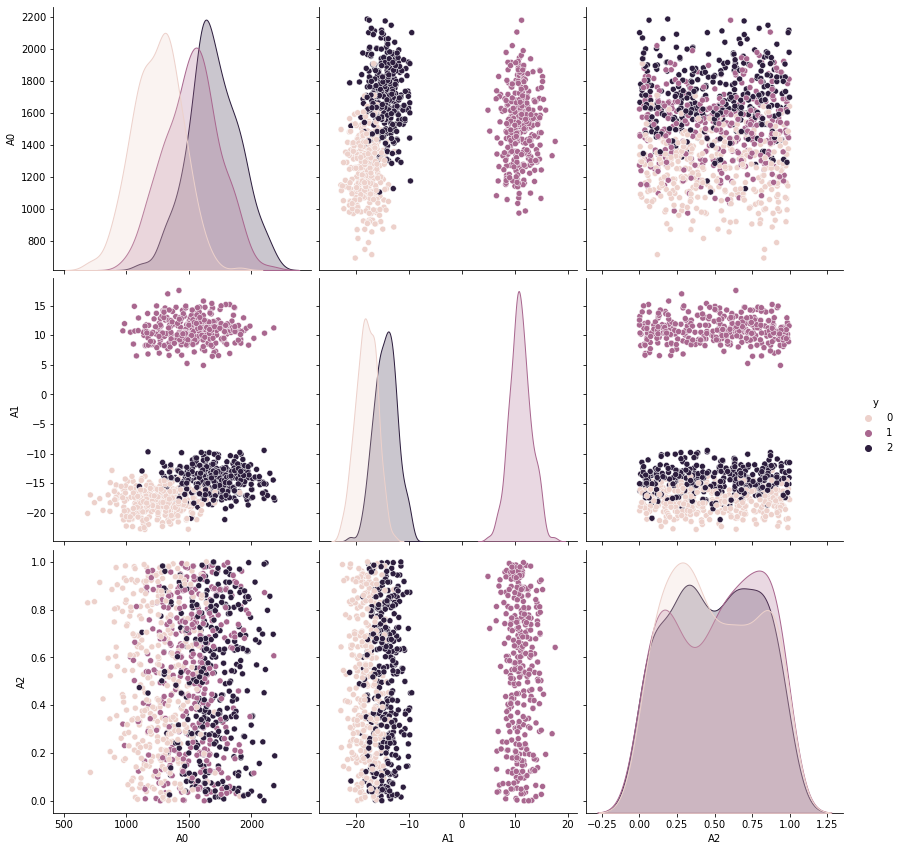

In [14]:
sns.pairplot(df,hue = 'y', height=4,);

use this pairlpot

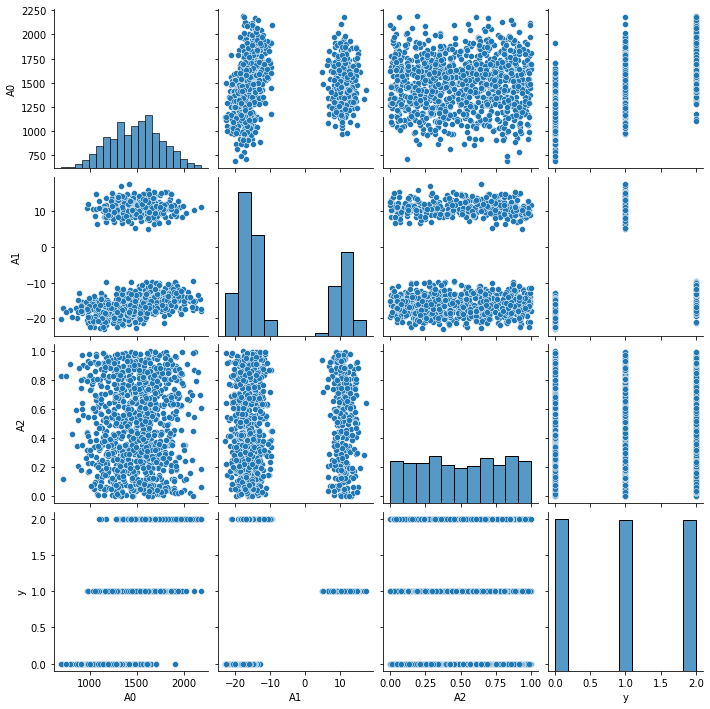

In [15]:
sns.pairplot(df)

In [16]:
# #X = df.drop(columns=['y'], axis=1).to_numpy()
# focus = [0,1]
# plt.scatter(X[:,focus[1]], X[:,focus[0]]
#             , c='white'          # color filling the data markers
#             , edgecolors='black' # edge color for data markers
#             , marker='o'         # data marker shape, e.g. triangles (v<>^), square (s), star (*), ...
#             , s=50)              # data marker size
# plt.grid()  # plots a grid on the data
# plt.show()

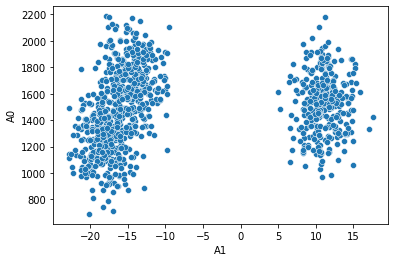

In [17]:
sns.scatterplot(x=df.iloc[:, 1], y=df.iloc[:, 0]);

### Comment:
From the pairplot we can see that ther are at least 2 clusters, on the left and on the right of the previous plotting. 
Now we will check the silhoutte to better find a parameter for cluster numbers

#2. find the best clustering schemefor X with a method of your choice, plot the silhouhette index for an appropriate range of parameters and show the chosen hyperparameter(s) 

In [18]:
k_range = range(2,11)

In [19]:
distortions = []
silhouette_scores = []
for i in k_range:
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=rnd_state)
    y_km = km.fit_predict(X)
    distortions.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X,y_km))
    

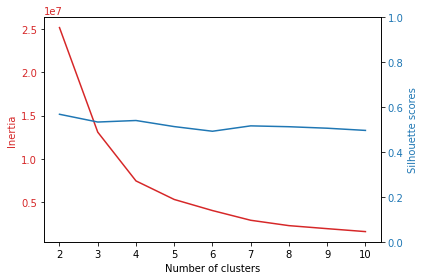

In [20]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(k_range, distortions, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Silhouette scores', color=color)  # we already handled the x-label with ax1
ax2.plot(k_range, silhouette_scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,1) # the axis for silhouette is [0,1]

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

As we can see, the interesting values of distorsion and silhouette score are defined by the elbows. 

Particularly, 3 and 4 could be a good parameter for the cluster number

Let's try 4

# 3.fit the clustering scheme store the cluster labels iny_km and output the silhouette score

In [21]:
good_k=4
km = KMeans(n_clusters=good_k,init='k-means++',n_init=10, max_iter=300, tol=1e-04,random_state=rnd_state)
y_km = km.fit_predict(X)

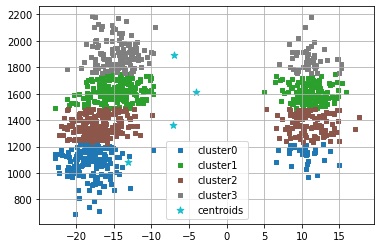

In [22]:
plot_clusters(X.to_numpy(),y_km,dim=(1,0), points = km.cluster_centers_)

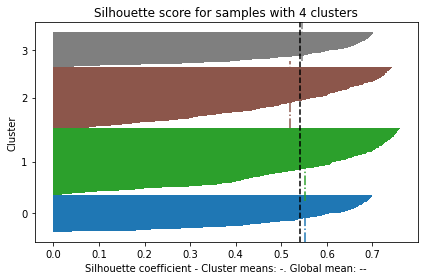

In [23]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0] # it is the number of rows
# Compute the Silhouette Coefficient for each sample, with the euclidean metric
silhouette_score_samples = silhouette_samples(X, y_km, metric='euclidean')
plt.title('Silhouette score for samples with {} clusters'.format(good_k))
plot_silhouette(silhouette_score_samples, y_km)

#4.use the labels in the last column of the input file as the “gold standard”for the clustering and compare y_km and y; for an effective comparison, each label in y_km must be remapped to the best label in y; compute and apply this re-mapping

# 5.produce the confusion matrix comparing y and y_km with sklearn.metrics.confusion_matrix

In [24]:
print(confusion_matrix(y, y_km))

[[149  32 152   1]
 [ 32 140 109  52]
 [  3 163  45 122]
 [  0   0   0   0]]


In [25]:
accuracy_score(y, y_km)

0.334

In [26]:
remap=df_remapped =remapping(y,y_km)
accuracy_score(y, remap)

0.421

In [27]:
print(confusion_matrix(y, remap))

[[149 152  32   1]
 [ 32 109 140  52]
 [  3  45 163 122]
 [  0   0   0   0]]


#6. consider possible pre-processing actions, repeat the fitting and evaluate as before the result of the new fitting

In [28]:
# from sklearn.preprocessing import MinMaxScaler
# mms = MinMaxScaler()
# X = mms.fit_transform(X)

In [29]:
X.max(axis=0)-X.min(axis=0)

A0    1495.073816
A1      40.429470
A2       0.999421
dtype: float64

In [30]:
Xn=Normalization(X)
Xn.max(axis=0)-Xn.min(axis=0)

A0    1.0
A1    1.0
A2    1.0
dtype: float64

In [31]:
Xs=Standardization(X)
Xs.max(axis=0)-Xs.min(axis=0)

A0    5.445467
A1    3.091514
A2    3.406152
dtype: float64

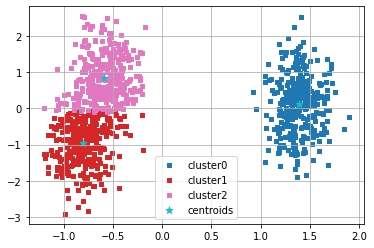

In [32]:
good_k=3
km = KMeans(n_clusters=good_k,init='k-means++',n_init=10, max_iter=300, tol=1e-04,random_state=rnd_state)
y_km = km.fit_predict(Xs)
plot_clusters(Xs.to_numpy(),y_km,dim=(1,0), points = km.cluster_centers_)


The value of the Silhouette score varies from -1 to 1. If the score is 1, the cluster is dense and well-separated than other clusters. A value near 0 represents overlapping clusters with samples very close to the decision boundary of the neighboring clusters. A negative score [-1, 0] indicates that the samples might have got assigned to the wrong clusters.

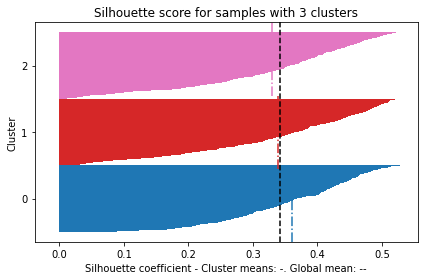

In [33]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0] # it is the number of rows
# Compute the Silhouette Coefficient for each sample, with the euclidean metric
silhouette_score_samples = silhouette_samples(Xs, y_km, metric='euclidean')
plt.title('Silhouette score for samples with {} clusters'.format(good_k))
plot_silhouette(silhouette_score_samples, y_km)

In [34]:
print(confusion_matrix(y, y_km))

[[  0 293  41]
 [333   0   0]
 [  0  40 293]]


In [35]:
accuracy_score(y, y_km)

0.293

In [36]:
remap=df_remapped =remapping(y,y_km)
accuracy_score(y, remap)

0.919

In [37]:
print(confusion_matrix(y, remap))

[[293   0  41]
 [  0 333   0]
 [ 40   0 293]]


In [38]:
silhouette_score_samples = silhouette_samples(Xs, remap, metric='euclidean')

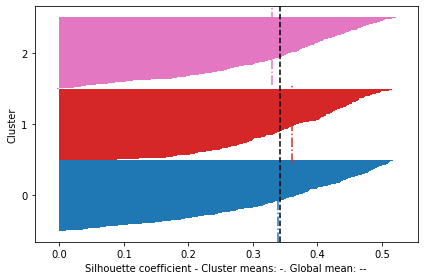

In [39]:
plot_silhouette(silhouette_score_samples, remap)

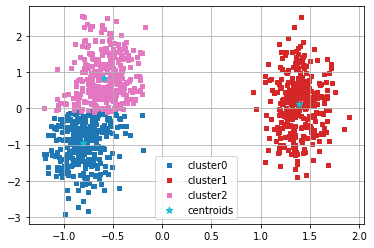

In [40]:
plot_clusters(Xs.to_numpy(),remap,dim=(1,0), points = km.cluster_centers_)

LEtt's retry silhoutte on Xs

In [41]:
distortions = []
silhouette_scores = []
for i in k_range:
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=rnd_state)
    y_km = km.fit_predict(Xs)
    distortions.append(km.inertia_)
    silhouette_scores.append(silhouette_score(Xs,y_km))
    

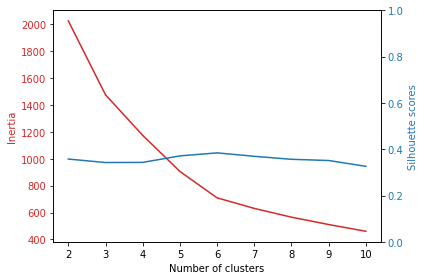

In [42]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(k_range, distortions, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Silhouette scores', color=color)  # we already handled the x-label with ax1
ax2.plot(k_range, silhouette_scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,1) # the axis for silhouette is [0,1]

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

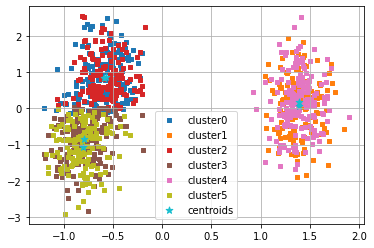

In [43]:
good_k=6
km = KMeans(n_clusters=good_k,init='k-means++',n_init=10, max_iter=300, tol=1e-04,random_state=rnd_state)
y_km = km.fit_predict(Xs)
plot_clusters(Xs.to_numpy(),y_km,dim=(1,0), points = km.cluster_centers_)


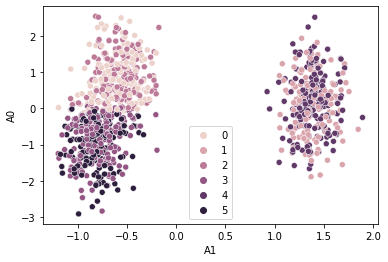

In [44]:
sns.scatterplot(x=Xs.iloc[:, 1], y=Xs.iloc[:, 0], hue=y_km);

In [45]:
remap=df_remapped =remapping(y,y_km)
accuracy_score(y, remap)

0.513

In [46]:
silhouette_score_samples = silhouette_samples(Xs, remap, metric='euclidean')

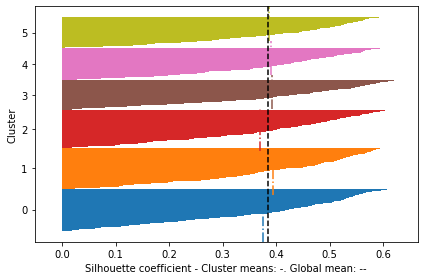

In [47]:
plot_silhouette(silhouette_score_samples, remap)